In [1]:
#Studente: Luca Sugamosto, matricola 0324613
#Traccia A1 - Riconoscimento di immagini MNIST-like

"L'obiettivo del progetto è addestrare e valutare uno o più modelli di classificazione multiclasse"
# EXTENDED MNIST: versione estesa del dataset MNIST, conentente lettere alfabetiche invece delle cifre.
#                 Viene fornito un file CSV con circa 80000 immagini relative a lettere maiuscole o minuscole.
#                 Nella classificazione non occorre distinguere tra maiuscole e minuscole, quindi le classi da
#                 riconoscere sono 26.
#                 Ogni riga del file contiene l'etichetta della classe corrispondente all'immagine (un intero tra 1 e 26),
#                 seguita da 784 interi compresi tra 0 e 255 che codificano l'intensità di grigio di ogni pixel.

"L'obiettivo del progetto è addestrare e valutare uno o più modelli di classificazione multiclasse"

In [2]:
#pip install numpy
#pip install pandas
#pip install tensorflow
#pip install scikeras

In [3]:
#Importazione di tutte le librerie utili/richieste
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import reciprocal
from scikeras.wrappers import KerasClassifier

#La seguente istruzione permette di generare i grafici all'interno dello stesso file in uso
%matplotlib inline

#Inizializzazione delle dimensioni degli elementi nel grafico
mpl.rc('axes', labelsize = 14)                       
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

In [4]:
#Fase di inizializzazione sul Data Set:
df = pd.read_csv("emnist-letters.csv")               #Lettura del file contenente i campioni del Data Set
X = df.iloc[:, 1:]                                   #Creazione della tabella delle istanze di ingresso
Y = df.iloc[:, 0]                                    #Creazione del vettore delle etichette associate alle istanze d'ingresso

#Normalizzazione degli attributi dei vettori d'ingresso così da avere valori compresi tra [0,1]
X = X/255

#Con la seguente istruzione si prende la tabella delle istanze di ingresso e si crea un vettore di 88800 elementi,
#dove ogni elemento è una matrice di dimensione 28 x 28 che sta ad indicare una singola instanza di ingresso
X = X.to_numpy().reshape(-1, 28, 28, order = "F")
print("Dimensione della variabile X:", X.shape, "\n")

#Con la seguente istruzione si prende la colonna delle etichette selezionata in precedenza e si trasforma
#in un vettore di dimensione 88800 x 1; in aggiunta il "-1" permette di indicare le 26 classi a partire
#dall'indice 0 e non 1. Quindi Y ha valori al suo interno compresi  tra 0 e 25
Y = Y.to_numpy()-1
print("Dimensione della variabile Y:", Y.shape, "\n")

#Suddivisione delle istanze del Data Set in Training Set e Test Set (rispettivamente 80% e 20%)
X_train_full, X_test, Y_train_full, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

#Suddivisione delle istanze del Training Set appena creato in Training Set e Validation Set (rispettivamente 85% e 15%)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train_full, Y_train_full, test_size = 0.15, random_state = 42)

print("Numero di campioni contenuti nel Training Set:", X_train.shape[0])
print("Numero di campioni contenuti nel Validation Set:", X_validation.shape[0])
print("Numero di campioni contenuti nel Test Set:", X_test.shape[0])

Dimensione della variabile X: (88800, 28, 28) 

Dimensione della variabile Y: (88800,) 

Numero di campioni contenuti nel Training Set: 60384
Numero di campioni contenuti nel Validation Set: 10656
Numero di campioni contenuti nel Test Set: 17760


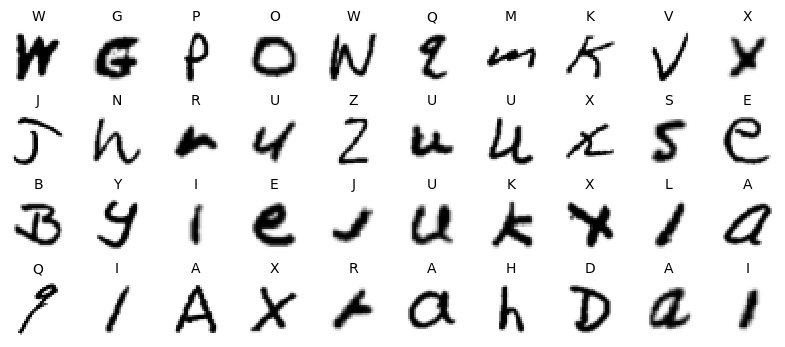

In [5]:
#Stampa a schermo di alcune istanze di ingresso (immagini di lettere scritte a mano)
#da passare successivamente in ingresso alla rete neurale
NN_input = X                                         #Si considera tutto il Data Set
NN_output = Y                                        #Si considera tutto il Data Set

#Sempre per un fatto legato alla stampa a schermo, si inizializza un vettore
#contenente tutte le 26 lettere dell'alfabeto per mostrare quale è la lettera reale
#associata all'immagine stampata
class_names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L",
               "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X",
               "Y", "Z"]

n_rows = 4                                           #Numero di immagini da stampare per riga
n_cols = 10                                          #Numero di immagini da stampare per colonna
plt.figure(figsize = (n_cols * 1, n_rows * 1))       #Dimensione delle singole immagini da stampare
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(NN_input[index], cmap = "binary", interpolation = "nearest")
        plt.axis('off')
        plt.title(class_names[NN_output[index]], fontsize = 10)
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)      #Spazio in altezza e larghezza tra le varie immagini
plt.show()

Nel seguente studio si cosidera un modello definito dall'utente e lo si addestra utilizzando
tre algoritmi di ottimizzazione diversi (SGD, RMSProp, Adam).

In [6]:
#Fase di creazione/inizializzazione della rete neurale:
#Il modello utilizzato è quello SEQUENZIALE, quindi la rete neurale si compone di strati densi
#(ciò significa che gli strati sono completamente connessi). Ogni strato possiede una propria
#funzione di attivazione ed un certo numero di neuroni scelti dall'utente sulla base di simulazioni 
model = keras.models.Sequential()                              

#1° implementazione possibile per la rete neurale (2 STRATI NASCOSTI)        
#model.add(keras.layers.Flatten(input_shape = [28, 28]))        #Strato d'ingresso con funzione identità
#model.add(keras.layers.Dense(256, activation = "relu"))        #1° strato nascosto con funzione ReLU
#model.add(keras.layers.Dense(128, activation = "relu"))        #2° strato nascosto con funzione ReLU
#model.add(keras.layers.Dense(26, activation = "softmax"))      #Strato d'uscita con funzione Softmax

#2° implementazione possibile per la rete neurale (3 STRATI NASCOSTI)
model.add(keras.layers.Flatten(input_shape = [28, 28]))         #Strato d'ingresso con funzione identità
model.add(keras.layers.Dense(256, activation = "relu"))         #1° strato nascosto con funzione ReLU
model.add(keras.layers.Dense(128, activation = "relu"))         #2° strato nascosto con funzione ReLU
model.add(keras.layers.Dense(64, activation = "relu"))          #3° strato nascosto con funzione ReLU
model.add(keras.layers.Dense(26, activation = "softmax"))       #Strato d'uscita con funzione Softmax

#3° implementazione possibile per la rete neurale (4 STRATI NASCOSTI)
#model.add(keras.layers.Flatten(input_shape = [28, 28]))        #Strato d'ingresso con funzione identità
#model.add(keras.layers.Dense(256, activation = "relu"))        #1° strato nascosto con funzione ReLU
#model.add(keras.layers.Dense(128, activation = "relu"))        #2° strato nascosto con funzione ReLU
#model.add(keras.layers.Dense(64, activation = "relu"))         #3° strato nascosto con funzione ReLU
#model.add(keras.layers.Dense(32, activation = "relu"))         #4° strato nascosto con funzione ReLU
#model.add(keras.layers.Dense(26, activation = "softmax"))      #Strato d'uscita con funzione Softmax

model.summary()                                                #Restituisce la descrizione sommaria della rete neurale
                                                               #appena definita


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 26)                1690      
                                                                 
Total params: 243802 (952.35 KB)
Trainable params: 243802 (952.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
model_2 = keras.models.Sequential()                              

#1° implementazione possibile per la rete neurale (2 STRATI NASCOSTI)        
#model_2.add(keras.layers.Flatten(input_shape = [28, 28]))        #Strato d'ingresso con funzione identità
#model_2.add(keras.layers.Dense(256, activation = "relu"))        #1° strato nascosto con funzione ReLU
#model_2.add(keras.layers.Dense(128, activation = "relu"))        #2° strato nascosto con funzione ReLU
#model_2.add(keras.layers.Dense(26, activation = "softmax"))      #Strato d'uscita con funzione Softmax

#2° implementazione possibile per la rete neurale (3 STRATI NASCOSTI)
model_2.add(keras.layers.Flatten(input_shape = [28, 28]))         #Strato d'ingresso con funzione identità
model_2.add(keras.layers.Dense(256, activation = "relu"))         #1° strato nascosto con funzione ReLU
model_2.add(keras.layers.Dense(128, activation = "relu"))         #2° strato nascosto con funzione ReLU
model_2.add(keras.layers.Dense(64, activation = "relu"))          #3° strato nascosto con funzione ReLU
model_2.add(keras.layers.Dense(26, activation = "softmax"))       #Strato d'uscita con funzione Softmax

#3° implementazione possibile per la rete neurale (4 STRATI NASCOSTI)
#model_2.add(keras.layers.Flatten(input_shape = [28, 28]))        #Strato d'ingresso con funzione identità
#model_2.add(keras.layers.Dense(256, activation = "relu"))        #1° strato nascosto con funzione ReLU
#model_2.add(keras.layers.Dense(128, activation = "relu"))        #2° strato nascosto con funzione ReLU
#model_2.add(keras.layers.Dense(64, activation = "relu"))         #3° strato nascosto con funzione ReLU
#model_2.add(keras.layers.Dense(32, activation = "relu"))         #4° strato nascosto con funzione ReLU
#model_2.add(keras.layers.Dense(26, activation = "softmax"))      #Strato d'uscita con funzione Softmax

model_2.summary()                                                #Restituisce la descrizione sommaria della rete neurale
                                                                 #appena definita
#---------------------------------------------------------------------------------------------------------------------
model_3 = keras.models.Sequential()                              

#1° implementazione possibile per la rete neurale (2 STRATI NASCOSTI)        
#model_3.add(keras.layers.Flatten(input_shape = [28, 28]))        #Strato d'ingresso con funzione identità
#model_3.add(keras.layers.Dense(256, activation = "relu"))        #1° strato nascosto con funzione ReLU
#model_3.add(keras.layers.Dense(128, activation = "relu"))        #2° strato nascosto con funzione ReLU
#model_3.add(keras.layers.Dense(26, activation = "softmax"))      #Strato d'uscita con funzione Softmax

#2° implementazione possibile per la rete neurale (3 STRATI NASCOSTI)
model_3.add(keras.layers.Flatten(input_shape = [28, 28]))         #Strato d'ingresso con funzione identità
model_3.add(keras.layers.Dense(256, activation = "relu"))         #1° strato nascosto con funzione ReLU
model_3.add(keras.layers.Dense(128, activation = "relu"))         #2° strato nascosto con funzione ReLU
model_3.add(keras.layers.Dense(64, activation = "relu"))          #3° strato nascosto con funzione ReLU
model_3.add(keras.layers.Dense(26, activation = "softmax"))       #Strato d'uscita con funzione Softmax

#3° implementazione possibile per la rete neurale (4 STRATI NASCOSTI)
#model_3.add(keras.layers.Flatten(input_shape = [28, 28]))        #Strato d'ingresso con funzione identità
#model_3.add(keras.layers.Dense(256, activation = "relu"))        #1° strato nascosto con funzione ReLU
#model_3.add(keras.layers.Dense(128, activation = "relu"))        #2° strato nascosto con funzione ReLU
#model_3.add(keras.layers.Dense(64, activation = "relu"))         #3° strato nascosto con funzione ReLU
#model_3.add(keras.layers.Dense(32, activation = "relu"))         #4° strato nascosto con funzione ReLU
#model_3.add(keras.layers.Dense(26, activation = "softmax"))      #Strato d'uscita con funzione Softmax

model_3.summary()                                                #Restituisce la descrizione sommaria della rete neurale
                                                                 #appena definita

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               200960    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 26)                1690      
                                                                 
Total params: 243802 (952.35 KB)
Trainable params: 243802 (952.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequen

In tutte e tre le seguenti parti di codice in cui sono inizializzate le caratteristiche
funzionali e gli algoritmi che dovranno usare i modelli, non vi è nessun accenno al valore
che il LEARNING RATE possiede, questo significa che è settato di default al valore 0.001.

In [8]:
#Fase di ottimizzazione dei parametri (w, b) della rete neurale per mezzo delll'algoritmo SGD:
"L'ottimizzazione è uno dei due argomenti necessari, insieme all'addestramento, per la compilazione di un modello"
model.compile(                                               #Settaggio delle funzioni/algoritmi che deve usare "model"
    loss = "sparse_categorical_crossentropy",                #Funzione di perdita per il calcolo dell'errore
    optimizer = keras.optimizers.SGD(),                      #Algoritmo di ottimizzazione dei parametri
    metrics = ["accuracy"]                                   #Funzione per valutare le prestazioni del modello
)

In [9]:
#Fase di ottimizzazione dei parametri (w, b) della rete neurale per mezzo dell'algoritmo RMSprop:
model_2.compile(                                             #Settaggio delle funzioni/algoritmi che deve usare "model_2"
    loss = "sparse_categorical_crossentropy",                #Funzione di perdita per il calcolo dell'errore
    optimizer = keras.optimizers.RMSprop(),                  #Algoritmo di ottimizzazione dei parametri
    metrics = ["accuracy"]                                   #Funzione per valutare le prestazioni del modello
)

In [10]:
#Fase di ottimizzazione dei parametri (w, b) della rete neurale per mezzo dell'algoritmo Adam:
model_3.compile(                                             #Settaggio delle funzioni/algoritmi che deve usare "model_3"
    loss = "sparse_categorical_crossentropy",                #Funzione di perdita per il calcolo dell'errore
    optimizer = keras.optimizers.Adam(),                     #Algoritmo di ottimizzazione dei parametri
    metrics = ["accuracy"]                                   #Funzione per valutare le prestazioni del modello
)

In [11]:
#Fase di addestramento della rete neurale e dei rispettivi parametri (w, b) del modello (1):
"L'addestramento è la fase più importante perchè consiste nel definire i valori ottimi dei parametri (w, b)"
print("-----Fit model on Training Set-----\n")
history = model.fit(                                       #Tale funzione "fit" viene assegnata alla variabile "history"
    X_train,                                               #così da graficarne successivamente l'andamento
    Y_train,
    batch_size = 32,                                       #Numero di campioni contenuti in ogni mini-batch
    epochs = 30,                                           #Numero di volte che tutti i campioni devono essere analizzati

    validation_data = (X_validation, Y_validation),        #Si passa il Validation Set per monitorare il valore 
                                                           #di perdita e di accuratezza su questo secondo insieme di dati
                                                           #alla fine di ogni epoca esaminata
    callbacks = [keras.callbacks.EarlyStopping(patience = 20)]
    #Utilizzo della tecnica di "Early Stopping" per terminare in anticipo l'addestramento,
    #nel caso in cui si verifica il fenomeno di sovra-adattamento e quindi di poca generalizzazione
    #Il parametro "patience" indica dopo quante epoche in cui il "val_loss" aumenta bisogna arrestare l'algoritmo
)

-----Fit model on Training Set-----

Epoch 1/30


1887/1887 [==============================] - 6s 3ms/step - loss: 1.8035 - accuracy: 0.5006 - val_loss: 1.1353 - val_accuracy: 0.6713
Epoch 2/30
1887/1887 [==============================] - 6s 3ms/step - loss: 0.9824 - accuracy: 0.7119 - val_loss: 0.8713 - val_accuracy: 0.7477
Epoch 3/30
1887/1887 [==============================] - 5s 3ms/step - loss: 0.7630 - accuracy: 0.7735 - val_loss: 0.6973 - val_accuracy: 0.7964
Epoch 4/30
1887/1887 [==============================] - 5s 3ms/step - loss: 0.6268 - accuracy: 0.8120 - val_loss: 0.5958 - val_accuracy: 0.8271
Epoch 5/30
1887/1887 [==============================] - 6s 3ms/step - loss: 0.5392 - accuracy: 0.8364 - val_loss: 0.5296 - val_accuracy: 0.8438
Epoch 6/30
1887/1887 [==============================] - 6s 3ms/step - loss: 0.4785 - accuracy: 0.8534 - val_loss: 0.5086 - val_accuracy: 0.8516
Epoch 7/30
1887/1887 [==============================] - 5s 3ms/step - loss: 0.4336 - accuracy: 0.

In [12]:
#Fase di addestramento della rete neurale e dei rispettivi parametri (w, b) del modello (2):
"L'addestramento è la fase più importante perchè consiste nel definire i valori ottimi dei parametri (w, b)"
print("-----Fit model on Training Set-----\n")
history_2 = model_2.fit(                                   #Tale funzione "fit" viene assegnata alla variabile "history"
    X_train,                                               #così da graficarne successivamente l'andamento
    Y_train,
    batch_size = 32,                                       #Numero di campioni contenuti in ogni mini-batch
    epochs = 30,                                           #Numero di volte che tutti i campioni devono essere analizzati
    
    validation_data = (X_validation, Y_validation),        #Si passa il Validation Set per monitorare il valore 
                                                           #di perdita e di accuratezza su questo secondo insieme di dati
                                                           #alla fine di ogni epoca esaminata
    callbacks = [keras.callbacks.EarlyStopping(patience = 20)]
    #Utilizzo della tecnica di "Early Stopping" per terminare in anticipo l'addestramento,
    #nel caso in cui si verifica il fenomeno di sovra-adattamento e quindi di poca generalizzazione
    #Il parametro "patience" indica dopo quante epoche in cui il "val_loss" aumenta bisogna arrestare l'algoritmo
)

-----Fit model on Training Set-----

Epoch 1/30
1887/1887 [==============================] - 8s 4ms/step - loss: 0.7915 - accuracy: 0.7587 - val_loss: 0.4972 - val_accuracy: 0.8469
Epoch 2/30
1887/1887 [==============================] - 7s 4ms/step - loss: 0.4234 - accuracy: 0.8658 - val_loss: 0.4358 - val_accuracy: 0.8639
Epoch 3/30
1887/1887 [==============================] - 7s 4ms/step - loss: 0.3483 - accuracy: 0.8882 - val_loss: 0.3838 - val_accuracy: 0.8804
Epoch 4/30
1887/1887 [==============================] - 7s 4ms/step - loss: 0.3086 - accuracy: 0.9003 - val_loss: 0.3925 - val_accuracy: 0.8817
Epoch 5/30
1887/1887 [==============================] - 7s 4ms/step - loss: 0.2823 - accuracy: 0.9084 - val_loss: 0.4173 - val_accuracy: 0.8848
Epoch 6/30
1887/1887 [==============================] - 7s 4ms/step - loss: 0.2640 - accuracy: 0.9145 - val_loss: 0.4264 - val_accuracy: 0.8841
Epoch 7/30
1887/1887 [==============================] - 8s 4ms/step - loss: 0.2515 - accuracy: 0.92

In [13]:
#Fase di addestramento della rete neurale e dei rispettivi parametri (w, b) del modello (3):
"L'addestramento è la fase più importante perchè consiste nel definire i valori ottimi dei parametri (w, b)"
print("-----Fit model on Training Set-----\n")
history_3 = model_3.fit(                                   #Tale funzione "fit" viene assegnata alla variabile "history"
    X_train,                                               #così da graficarne successivamente l'andamento
    Y_train,
    batch_size = 32,                                       #Numero di campioni contenuti in ogni mini-batch
    epochs = 30,                                           #Numero di volte che tutti i campioni devono essere analizzati
    
    validation_data = (X_validation, Y_validation),        #Si passa il Validation Set per monitorare il valore 
                                                           #di perdita e di accuratezza su questo secondo insieme di dati
                                                           #alla fine di ogni epoca esaminata
    callbacks = [keras.callbacks.EarlyStopping(patience = 20)]
    #Utilizzo della tecnica di "Early Stopping" per terminare in anticipo l'addestramento,
    #nel caso in cui si verifica il fenomeno di sovra-adattamento e quindi di poca generalizzazione
    #Il parametro "patience" indica dopo quante epoche in cui il "val_loss" aumenta bisogna arrestare l'algoritmo
)

-----Fit model on Training Set-----

Epoch 1/30
1887/1887 [==============================] - 9s 4ms/step - loss: 0.7898 - accuracy: 0.7579 - val_loss: 0.5014 - val_accuracy: 0.8416
Epoch 2/30
1887/1887 [==============================] - 8s 4ms/step - loss: 0.4139 - accuracy: 0.8648 - val_loss: 0.4006 - val_accuracy: 0.8769
Epoch 3/30
1887/1887 [==============================] - 8s 4ms/step - loss: 0.3275 - accuracy: 0.8914 - val_loss: 0.3767 - val_accuracy: 0.8826
Epoch 4/30
1887/1887 [==============================] - 8s 4ms/step - loss: 0.2766 - accuracy: 0.9047 - val_loss: 0.3594 - val_accuracy: 0.8861
Epoch 5/30
1887/1887 [==============================] - 8s 4ms/step - loss: 0.2409 - accuracy: 0.9153 - val_loss: 0.3755 - val_accuracy: 0.8827
Epoch 6/30
1887/1887 [==============================] - 8s 4ms/step - loss: 0.2160 - accuracy: 0.9236 - val_loss: 0.3529 - val_accuracy: 0.8927
Epoch 7/30
1887/1887 [==============================] - 8s 4ms/step - loss: 0.1950 - accuracy: 0.92

1° grafico associato al modello "model", addestrato con algoritmo di ottimizzazione "SGD":

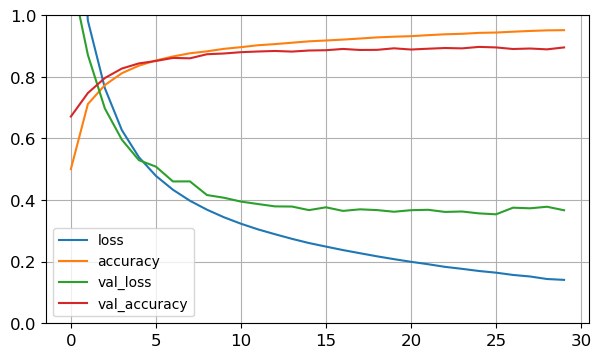

In [14]:
#Rappresentazione grafica dei risultati ottenuti in termini
#di perdita ed accuratezza durante la fase di addestramento
pd.DataFrame(history.history).plot(figsize = (7, 4))           #Dimensione del grafico 2D
plt.grid(True)                                                 #Presenza della griglia del grafico 2D
plt.gca().set_ylim(0, 1)                                       #Range dai valori assunti dagli assi
plt.show()

2° grafico associato al modello "model_2", addestrato con algoritmo di ottimizzazione "RMSProp":

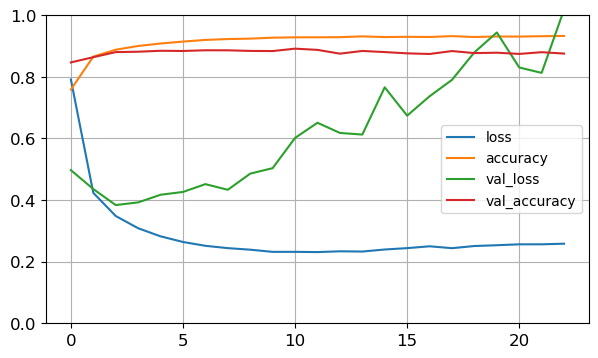

In [15]:
#Rappresentazione grafica dei risultati ottenuti in termini
#di perdita ed accuratezza durante la fase di addestramento
pd.DataFrame(history_2.history).plot(figsize = (7, 4))         #Dimensione del grafico 2D
plt.grid(True)                                                 #Presenza della griglia del grafico 2D
plt.gca().set_ylim(0, 1)                                       #Range dai valori assunti dagli assi
plt.show()

3° grafico associato al modello "model_3", addestrato con algoritmo di ottimizzazione "Adam":

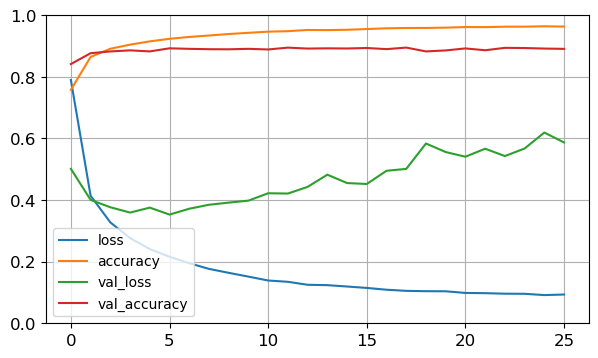

In [16]:
#Rappresentazione grafica dei risultati ottenuti in termini
#di perdita ed accuratezza durante la fase di addestramento
pd.DataFrame(history_3.history).plot(figsize = (7, 4))         #Dimensione del grafico 2D
plt.grid(True)                                                 #Presenza della griglia del grafico 2D
plt.gca().set_ylim(0, 1)                                       #Range dai valori assunti dagli assi
plt.show()

In [17]:
#Verifica della bontà dei parametri (w, b) ottenuti utilizzando come 
#algoritmo di ottimizzazione il SGD.
#Si utilizza in questo caso lo stesso modello con in ingresso il Test Set
print("-----Evaluate on Test Set-----\n")
print("Valori di perdita ed accuratezza sul Test Set (1):")
results = model.evaluate(X_test, Y_test, batch_size = 32)      #Con questa funzione si utilizza la rete neurale già creata
                                                               #con i parametri addestrati, per calcolare accuratezza e
                                                               #perdita sul Test Set

-----Evaluate on Test Set-----

Valori di perdita ed accuratezza sul Test Set (1):
555/555 [==============================] - 1s 2ms/step - loss: 0.3645 - accuracy: 0.8988


In [18]:
#Verifica della bontà dei parametri (w, b) ottenuti utilizzando come 
#algoritmo di ottimizzazione il RMSProp.
#Si utilizza in questo caso lo stesso modello con in ingresso il Test Set
print("-----Evaluate on Test Set-----\n")
print("Valori di perdita ed accuratezza sul Test Set (2):")
results_2 = model_2.evaluate(X_test, Y_test, batch_size = 32)  #Con questa funzione si utilizza la rete neurale già creata
                                                               #con i parametri addestrati, per calcolare accuratezza e
                                                               #perdita sul Test Set

-----Evaluate on Test Set-----

Valori di perdita ed accuratezza sul Test Set (2):
555/555 [==============================] - 1s 2ms/step - loss: 1.0549 - accuracy: 0.8732


In [19]:
#Verifica della bontà dei parametri (w, b) ottenuti utilizzando come 
#algoritmo di ottimizzazione il Adam.
#Si utilizza in questo caso lo stesso modello con in ingresso il Test Set
print("-----Evaluate on Test Set-----\n")
print("Valori di perdita ed accuratezza sul Test Set (3):")
results_3 = model_3.evaluate(X_test, Y_test, batch_size = 32)  #Con questa funzione si utilizza la rete neurale già creata
                                                               #con i parametri addestrati, per calcolare accuratezza e
                                                               #perdita sul Test Set

-----Evaluate on Test Set-----

Valori di perdita ed accuratezza sul Test Set (3):
555/555 [==============================] - 1s 2ms/step - loss: 0.6077 - accuracy: 0.8950


Nello studio seguente, si considera una funzione che permette la creazione del modello, dati in ingresso gli iperparametri: numero di strati, numero di neuroni per strato, valore de learning rate.
Successivamente si generaro ed addestrano "n" modelli diversi che permetteranno di calcolare i valori migliore per ogni iperparametro

In [20]:
#Utilizzo della funzione "build_model" per la creazione del modello da addestrare. 
#Essa prende in ingresso gli iperparametri della rete neurale 
#(numero di strati nascosti, numero di neuroni, valore del learning rate) e restituisce un modello
def build_model (n_hidden = 3, n_units = 100, learning_rate = 0.01):
    #Il modello utilizzato è quello SEQUENZIALE, quindi la rete neurale si compone di strati densi
    #(ciò significa che gli strati sono completamente connessi). Ogni strato possiede una propria
    #funzione di attivazione ed un certo numero di neuroni scelti casualmente
    model = keras.models.Sequential()
            
    model.add(keras.layers.Flatten(input_shape = [28, 28]))               #Strato d'ingresso con funzione Identità
    for i in range(n_hidden):
        #Creando in questo modo gli strati nascosti si ha che tutti essi
        #possiedono lo stesso numero di neuroni
        model.add(keras.layers.Dense(n_units, activation = "relu"))       #Strato nascosto i-esimo con funzione ReLU
    model.add(keras.layers.Dense(26, activation = "softmax"))             #Strato d'uscita con funzione Softmax                                                  
    
    model.summary()                                                       #Restituisce la descrizione della rete
                                                                          #neurale appena definita
    
    model.compile(loss = "sparse_categorical_crossentropy",               #Funzione di perdita
              optimizer = keras.optimizers.SGD(learning_rate),            #Algoritmo di ottimizzazione
              metrics = ["accuracy"])                                     #Funzione di valutazione
    
    return model

In [21]:
#Inizializzazione degli intervalli di valore che gli iperparametri possono assumere
#durante la fase di addestramento
param_distribs = {
    "n_hidden" : [1, 2, 3, 4],                                            #Numero di strati nascosti possibili
    "n_units" : np.arange(16, 256).tolist(),                              #Numero di neuroni possibili per ogni strato
    "learning_rate": reciprocal(1e-4, 5e-2).rvs(1000).tolist(),           #Valori di Learning Rate possibili
}   #"rvs(1000)" permette di definire 1000 campioni casuali dalla distribuzione specificata, mentre
    #"tolist()" permette di convertire l'insieme dei campioni presi in una lista 

#Inizializzazione di una classe Keras contenente la funzione utile alla creazione del modello
#e le caratteristiche più importanti come funzione di perdita e iperparametri
keras_clf = KerasClassifier(
    model = build_model,                                                  #Creazione del modello da addestrare
    loss = "sparse_categorical_crossentropy",                             #Funzione di perdita
    n_units = 32, n_hidden = 2, learning_rate = 0.001                     #Iperparametri utilizzati
)

#La seguente funzione permette di creare un oggetto per la ricerca dei parametri ottimi.
#Porre in ingresso la classe (modello), le distribuzioni (gli intervalli di valori degli iperparametri) ed alcuni parametri
#della funzione "RandomizedSearchCV"
rnd_search_cv = RandomizedSearchCV(keras_clf, param_distribs, n_iter = 20, cv = 2, verbose = 2)    
#Il parametro "n_iter" indica quanti modelli diversi generare e quindi addestrare
#Il parametro "cv" indica per quante volte addestrare uno specifico modello. Dato questo parametro si ha che
#Il parametro "verbose" indica il tipo di messaggio che viene stampato a schermo alla fine di ogni iterazione
#il numero di batch totali da usare viene diviso per "cv" ed ad ogni addestramento viene usato solo 
#quel numero batch calcolato. 

#Fase di addestramento dei modelli:
#La seguente funzione permette l'addestramento del modello creato con la funzione precedente
rnd_search_cv.fit(X_train, Y_train, 
                  batch_size = 32, 
                  epochs = 30,
                  validation_data = (X_validation, Y_validation),
                  #Si introduce la tecnica di arresto anticipato; il parametro in ingresso indica
                  #il numero di epoche senza miglioramento dopo le quali l'algoritmo viene interrotto
                  callbacks = [keras.callbacks.EarlyStopping(patience = 10)]
                 )

Fitting 2 folds for each of 20 candidates, totalling 40 fits
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 52)                40820     
                                                                 
 dense_13 (Dense)            (None, 52)                2756      
                                                                 
 dense_14 (Dense)            (None, 26)                1378      
                                                                 
Total params: 44954 (175.60 KB)
Trainable params: 44954 (175.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
944/944 [==============================] - 3s 3ms/step - loss: 2.2584 - accu

RandomizedSearchCV(cv=2,
                   estimator=KerasClassifier(learning_rate=0.001, loss='sparse_categorical_crossentropy', model=<function build_model at 0x000001D91D15B9C0>, n_hidden=2, n_units=32),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.0030954833411850164,
                                                          0.0005349822570511461,
                                                          0.0005768165983800037,
                                                          0.00013242283215318234,
                                                          0.0029885620204726077,
                                                          0.011295503...
                                                          0.028797136094710962,
                                                          0.02595425032332085,
                                                          0.0019879741878100054,
                                                          0.0002967085660054458,
                                                          0.00034094035590821335,
                                                          0.02759186508545138,
                                                          0.00020236349075191128,
                                                          0.01425010192190004,
                                                          0.013190911102453465,
                                                          0.0009068955294257659, ...],
                                        'n_hidden': [1, 2, 3, 4],
                                        'n_units': [16, 17, 18, 19, 20, 21, 22,
                                                    23, 24, 25, 26, 27, 28, 29,
                                                    30, 31, 32, 33, 34, 35, 36,
                                                    37, 38, 39, 40, 41, 42, 43,
                                                    44, 45, ...]},
                   verbose=2)

In [22]:
#A questo punto si ottiene la combinazione di iperparametri con cui si ha avuto risultati migliori
#e si ottiene anche il modello (quindi i parametri (w, b)) con cui si ha avuto risultati migliori
iperparameters = rnd_search_cv.best_params_
print("Iperparametri ottimi trovati:", iperparameters,"\n")

#Il modello ottimo dovrà essere utilizzato sul Test Set per valutare l'errore di generalizzazione
bestModel = rnd_search_cv.best_estimator_.model_

print("Funzione di perdita - Valore di accuratezza sul Test Set:")
results = bestModel.evaluate(X_test, Y_test)

Iperparametri ottimi trovati: {'n_units': 141, 'n_hidden': 4, 'learning_rate': 0.012688384692920699} 

Funzione di perdita - Valore di accuratezza sul Test Set:
555/555 [==============================] - 1s 2ms/step - loss: 0.3778 - accuracy: 0.8972


In [23]:
#Creazione di un nuovo modello usando gli iperparametri ottimi trovati nella fase precedente.
#I parametri (w, b) di tale modello vanno addestrati.
#Questo passaggio viene fatto per controllare se effettivamente i valori degli iperparametri
#calcolati permettono di creare un modello che restituisca una percentuale di predizione alta.

#Il modello utilizzato è quello SEQUENZIALE, quindi la rete neurale si compone di strati densi
#(ciò significa che gli strati sono completamente connessi). Ogni strato possiede una propria
#funzione di attivazione ed un certo numero di neuroni scelti dall'utente sulla base di simulazioni 
bestModel = keras.models.Sequential()

bestModel.add(keras.layers.Flatten(input_shape = [28, 28]))         #Strato d'ingresso con funzione identità

bestModel.add(keras.layers.Dense(141, activation = "relu"))         #1° strato nascosto con funzione ReLU
bestModel.add(keras.layers.Dense(141, activation = "relu"))         #2° strato nascosto con funzione ReLU
bestModel.add(keras.layers.Dense(141, activation = "relu"))         #3° strato nascosto con funzione ReLU
bestModel.add(keras.layers.Dense(141, activation = "relu"))         #3° strato nascosto con funzione ReLU

bestModel.add(keras.layers.Dense(26, activation = "softmax"))       #Strato d'uscita con funzione Softmax

bestModel.summary()
bestModel.compile(loss = "sparse_categorical_crossentropy",                              #Funzione di perdita
              optimizer = keras.optimizers.SGD(learning_rate = 0.012688384692920699),    #Algoritmo di ottimizzazione
              metrics = ["accuracy"])                                                    #Funzione di valutazione

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_44 (Flatten)        (None, 784)               0         
                                                                 
 dense_157 (Dense)           (None, 141)               110685    
                                                                 
 dense_158 (Dense)           (None, 141)               20022     
                                                                 
 dense_159 (Dense)           (None, 141)               20022     
                                                                 
 dense_160 (Dense)           (None, 141)               20022     
                                                                 
 dense_161 (Dense)           (None, 26)                3692      
                                                                 
Total params: 174443 (681.42 KB)
Trainable params: 17

In [24]:
#Fase di addestramento della nuova rete neurale "bestModel":
"L'addestramento è la fase più importante perchè consiste nel definire i valori ottimi dei parametri (w, b)"
print("-----Fit model on Training Set-----\n")
history = bestModel.fit(                                   #Tale funzione viene assegnata alla variabile "history" così
    X_train,                                               #da graficarne successivamente l'andamento nel tempo
    Y_train,
    batch_size = 32,                                       #Numero di campioni contenuti in ogni mini-batch
    epochs = 30,                                           #Numero di volte che tutti i campioni devono essere analizzati
    validation_data = (X_validation, Y_validation),        #Si passa il Validation Set per monitorare la perdita 
                                                           #di convalida e le metriche alla fine di ogni epoca
    
    #Si introduce la tecnica di arresto anticipato; il parametro in ingresso indica
    #il numero di epoche senza miglioramento dopo le quali l'algoritmo viene interrotto
    callbacks = [keras.callbacks.EarlyStopping(patience = 10)]
)

-----Fit model on Training Set-----

Epoch 1/30
1887/1887 [==============================] - 7s 3ms/step - loss: 1.7740 - accuracy: 0.4873 - val_loss: 1.0671 - val_accuracy: 0.6897
Epoch 2/30
1887/1887 [==============================] - 6s 3ms/step - loss: 0.8863 - accuracy: 0.7347 - val_loss: 0.7618 - val_accuracy: 0.7720
Epoch 3/30
1887/1887 [==============================] - 6s 3ms/step - loss: 0.6516 - accuracy: 0.8011 - val_loss: 0.6194 - val_accuracy: 0.8172
Epoch 4/30
1887/1887 [==============================] - 6s 3ms/step - loss: 0.5376 - accuracy: 0.8331 - val_loss: 0.5468 - val_accuracy: 0.8300
Epoch 5/30
1887/1887 [==============================] - 6s 3ms/step - loss: 0.4705 - accuracy: 0.8522 - val_loss: 0.5030 - val_accuracy: 0.8471
Epoch 6/30
1887/1887 [==============================] - 6s 3ms/step - loss: 0.4226 - accuracy: 0.8653 - val_loss: 0.4598 - val_accuracy: 0.8584
Epoch 7/30
1887/1887 [==============================] - 6s 3ms/step - loss: 0.3852 - accuracy: 0.87

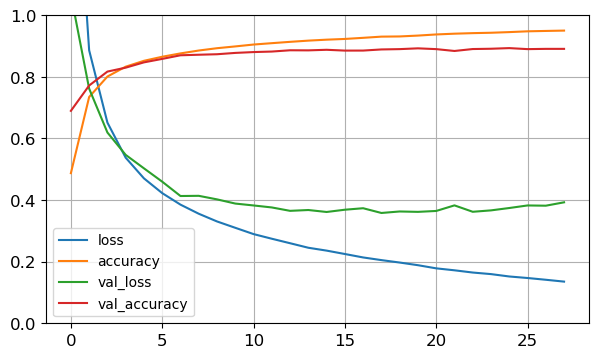

In [25]:
#Rappresentazione grafica dei risultati ottenuti in termini
#di perdita ed accuratezza durante la fase di addestramento
pd.DataFrame(history.history).plot(figsize = (7, 4))           #Dimensione del grafico 2D
plt.grid(True)                                                 #Presenza della griglia del grafico 2D
plt.gca().set_ylim(0, 1)                                       #Range dai valori assunti dagli assi
plt.show()

Con le prossime istruzioni si studia l'addestramento ed il comportamento di una Convolutional Neural Network (leNet-5).
Questa ha una struttura ben definita a priori; inoltre, anche in questo caso si utilizza un learning rate di default, cioè pari a 0,001.
Sono inizializzate due CNN, che differiscono per funzione di attivazione utilizzata (ad una la "sigmoid" mentre all'altra la "relu").

In [26]:
#Affinchè i vettori d'ingresso possano essere analizzati dalla CNN
#bisogna ridimensionare le istanze d'ingresso del Data Set in modo 
#da avere un singolo canale di uscita
X_train2 = X_train.reshape(-1, 28, 28, 1)            #il parametro "1" indica il fatto di avere un solo canale di uscita
X_validation2 = X_validation.reshape(-1, 28, 28, 1)  #il parametro "1" indica il fatto di avere un solo canale di uscita
X_test2 = X_test.reshape(-1, 28, 28, 1)              #il parametro "1" indica il fatto di avere un solo canale di uscita

print("Dimensioni dei campioni del Training Set:", X_train2.shape)
print("Dimensione dei campioni del Validation Set:", X_validation2.shape)
print("Dimensione dei campioni del Test Set:", X_test2.shape)

Dimensioni dei campioni del Training Set: (60384, 28, 28, 1)
Dimensione dei campioni del Validation Set: (10656, 28, 28, 1)
Dimensione dei campioni del Test Set: (17760, 28, 28, 1)


In [27]:
#Fase di implementazione della CNN LeNet:
    #Si compone di strati convoluzionali e strati di aggregazione alternati
    #per poi terminare con strati completamente connessi (strati densi)
    
    #I parametri associati ad ogni strato sono caratteristici della rete neurale LeNet.
    #La funzione di attivazione per gli strati nascosti è la "sigmoide"
lenet = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters = 6, kernel_size = 5, activation = 'sigmoid', padding = 'same', input_shape = (28, 28, 1)),
        tf.keras.layers.AvgPool2D(pool_size = 2, strides = 2),
        tf.keras.layers.Conv2D(filters = 16, kernel_size = 5,activation = 'sigmoid', padding = "valid"),
        tf.keras.layers.AvgPool2D(pool_size = 2, strides = 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation = 'sigmoid'),
        tf.keras.layers.Dense(84, activation = 'sigmoid'),
        tf.keras.layers.Dense(26, activation = "softmax")])

lenet.compile(
    loss = "sparse_categorical_crossentropy",                #Funzione di perdita per il calcolo dell'errore
    optimizer = keras.optimizers.Adam(),                     #Algoritmo di ottimizzazione dei parametri
    metrics = ["accuracy"]                                   #Funzione per valutare le prestazioni del modello
)

lenet.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten_45 (Flatten)        (None, 400)               0         
                                                                 
 dense_162 (Dense)           (None, 120)             

In [28]:
#Fase di addestramento della CNN (1):
history = lenet.fit(X_train2, 
                    Y_train, 
                    batch_size = 32,                                  #Numero di campioni contenuti in ogni mini-batch
                    epochs = 45,                                      #Numero di volte che tutti i campioni devono essere analizzati
                    validation_data = (X_validation2, Y_validation),  #Si passa il Validation Set per monitorare la perdita 
                                                                      #di convalida e le metriche alla fine di ogni epoca
                    
                    #Si introduce la tecnica di arresto anticipato; il parametro in ingresso indica
                    #il numero di epoche senza miglioramento dopo le quali l'algoritmo viene interrotto
                    callbacks = [keras.callbacks.EarlyStopping(patience = 15)])

#Salvataggio dei valori ottenuti durante l'addestramento tramite la
#variabile "history" per poter successivamente graficarne l'andamento

Epoch 1/45
1887/1887 [==============================] - 11s 5ms/step - loss: 1.8187 - accuracy: 0.4818 - val_loss: 0.9658 - val_accuracy: 0.7167
Epoch 2/45
1887/1887 [==============================] - 10s 5ms/step - loss: 0.7483 - accuracy: 0.7755 - val_loss: 0.6170 - val_accuracy: 0.8165
Epoch 3/45
1887/1887 [==============================] - 11s 6ms/step - loss: 0.5198 - accuracy: 0.8405 - val_loss: 0.4661 - val_accuracy: 0.8582
Epoch 4/45
1887/1887 [==============================] - 11s 6ms/step - loss: 0.4182 - accuracy: 0.8691 - val_loss: 0.3926 - val_accuracy: 0.8775
Epoch 5/45
1887/1887 [==============================] - 11s 6ms/step - loss: 0.3597 - accuracy: 0.8856 - val_loss: 0.3624 - val_accuracy: 0.8838
Epoch 6/45
1887/1887 [==============================] - 11s 6ms/step - loss: 0.3207 - accuracy: 0.8967 - val_loss: 0.3339 - val_accuracy: 0.8937
Epoch 7/45
1887/1887 [==============================] - 11s 6ms/step - loss: 0.2910 - accuracy: 0.9057 - val_loss: 0.3030 - val_ac

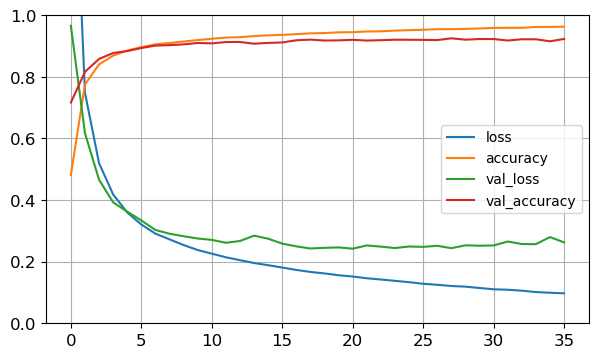

In [29]:
#Rappresentazione grafica dei risultati ottenuti in termini
#di perdita ed accuratezza durante la fase di addestramento
pd.DataFrame(history.history).plot(figsize = (7, 4))           #Dimensione del grafico 2D
plt.grid(True)                                                 #Presenza della griglia del grafico 2D
plt.gca().set_ylim(0, 1)                                       #Range dai valori assunti dagli assi
plt.show()

In [30]:
#Verifica della bontà dei parametri (w, b) ottenuti utilizzando come 
#algoritmo di ottimizzazione il Adam.
#Si utilizza in questo caso lo stesso modello con in ingresso il Test Set
print("-----Evaluate on Test Set-----\n")
print("Valori di perdita ed accuratezza sul Test Set (1):")
results = lenet.evaluate(X_test2, Y_test, batch_size = 32)     #Con questa funzione si utilizza la rete neurale già creata
                                                               #con i parametri addestrati, per calcolare accuratezza e
                                                               #perdita sul Test Set

-----Evaluate on Test Set-----

Valori di perdita ed accuratezza sul Test Set (1):
555/555 [==============================] - 2s 3ms/step - loss: 0.2604 - accuracy: 0.9270


Nella seguente porzione di codice si inizializza ed addestra una seconda CNN LeNet, che a differenza della prima utilizza come funzione di attivazione la reLU:

In [31]:
#E' possibile considerare la stessa Convolutional Neural Network di prima, utilizzando
#però al posto della funzione di attivazione "sigmoide", la funzione di attivazione "reLU"
#studiando le eventuali differenze

#Fase di implementazione della CNN LeNet:
    #Si compone di strati convoluzionali e strati di aggregazione alternati,
    #per poi terminare in strati completamente connessi (strati densi)
    
    #I parametri associati ad ogni strato sono caratteristici della rete neurale LeNet.
    #La funzione di attivazione per gli strati nascosti è la "reLU"
lenet_2 = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(filters = 6, kernel_size = 5, activation = 'relu', padding = 'same', input_shape = (28, 28, 1)),
          tf.keras.layers.AvgPool2D(pool_size = 2, strides = 2),
          tf.keras.layers.Conv2D(filters = 16, kernel_size = 5,activation = 'relu', padding = "valid"),
          tf.keras.layers.AvgPool2D(pool_size = 2, strides = 2),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(120, activation = 'relu'),
          tf.keras.layers.Dense(84, activation = 'relu'),
          tf.keras.layers.Dense(26, activation = "softmax")])

lenet_2.compile(
    loss = "sparse_categorical_crossentropy",                #Funzione di perdita per il calcolo dell'errore
    optimizer = keras.optimizers.Adam(),                     #Algoritmo di ottimizzazione dei parametri
    metrics = ["accuracy"]                                   #Funzione per valutare le prestazioni del modello
)

lenet_2.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_2 (Avera  (None, 14, 14, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_3 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten_46 (Flatten)        (None, 400)               0         
                                                                 
 dense_165 (Dense)           (None, 120)             

In [32]:
#Fase di addestramento della CNN:
history_2 = lenet_2.fit(X_train2, 
                    Y_train, 
                    batch_size = 32,                                  #Numero di campioni contenuti in ogni mini-batch
                    epochs = 45,                                      #Numero di volte che tutti i campioni devono essere analizzati
                    validation_data = (X_validation2, Y_validation),  #Si passa il Validation Set per monitorare la perdita 
                                                                      #di convalida e le metriche alla fine di ogni epoca
                    
                    #Si introduce la tecnica di arresto anticipato; il parametro in ingresso indica
                    #il numero di epoche senza miglioramento dopo le quali l'algoritmo viene interrotto
                    callbacks = [keras.callbacks.EarlyStopping(patience = 15)])

#Salvataggio dei valori ottenuti durante l'addestramento tramite la
#variabile "history" per poter successivamente graficarne l'andamento

Epoch 1/45
1887/1887 [==============================] - 11s 5ms/step - loss: 0.7207 - accuracy: 0.7789 - val_loss: 0.3777 - val_accuracy: 0.8788
Epoch 2/45
1887/1887 [==============================] - 9s 5ms/step - loss: 0.3300 - accuracy: 0.8909 - val_loss: 0.3249 - val_accuracy: 0.8946
Epoch 3/45
1887/1887 [==============================] - 10s 6ms/step - loss: 0.2656 - accuracy: 0.9087 - val_loss: 0.2661 - val_accuracy: 0.9137
Epoch 4/45
1887/1887 [==============================] - 10s 5ms/step - loss: 0.2297 - accuracy: 0.9205 - val_loss: 0.2562 - val_accuracy: 0.9138
Epoch 5/45
1887/1887 [==============================] - 11s 6ms/step - loss: 0.2029 - accuracy: 0.9299 - val_loss: 0.2502 - val_accuracy: 0.9172
Epoch 6/45
1887/1887 [==============================] - 11s 6ms/step - loss: 0.1862 - accuracy: 0.9337 - val_loss: 0.2419 - val_accuracy: 0.9184
Epoch 7/45
1887/1887 [==============================] - 10s 5ms/step - loss: 0.1705 - accuracy: 0.9376 - val_loss: 0.2492 - val_acc

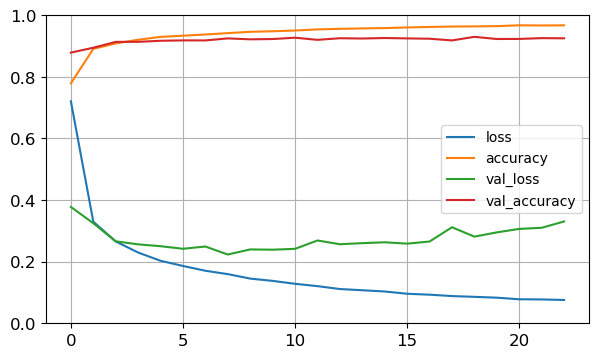

In [33]:
#Rappresentazione grafica dei risultati ottenuti in termini
#di perdita ed accuratezza durante la fase di addestramento
pd.DataFrame(history_2.history).plot(figsize = (7, 4))         #Dimensione del grafico 2D
plt.grid(True)                                                 #Presenza della griglia del grafico 2D
plt.gca().set_ylim(0, 1)                                       #Range dai valori assunti dagli assi
plt.show()

In [34]:
#Verifica della bontà dei parametri (w, b) ottenuti utilizzando come 
#algoritmo di ottimizzazione il Adam.
#Si utilizza in questo caso lo stesso modello con in ingresso il Test Set
print("-----Evaluate on Test Set-----\n")
print("Valori di perdita ed accuratezza sul Test Set (2):")
results = lenet_2.evaluate(X_test2, Y_test, batch_size = 32)   #Con questa funzione si utilizza la rete neurale già creata
                                                               #con i parametri addestrati, per calcolare accuratezza e
                                                               #perdita sul Test Set

-----Evaluate on Test Set-----

Valori di perdita ed accuratezza sul Test Set (2):
555/555 [==============================] - 1s 3ms/step - loss: 0.3456 - accuracy: 0.9303
